In [60]:
import torch
import torch.nn as nn
import torch.fft as fft
import numpy as np

# Synthetic dataset generator
def generate_dataset(num_samples=4000, nx=64, nt=32):
    x = torch.linspace(0, 1, nx)
    t = torch.linspace(0, 1, nt)
    X, T = torch.meshgrid(x, t, indexing="ij")
    
    S_all, phi_all = [], []
    for _ in range(num_samples):
        A = torch.rand(1) * 2 - 1        # amplitude [-1,1]
        k = torch.randint(1, 4, (1,))    # frequency 1-3
        alpha = torch.rand(1) * 2        # decay rate [0,2]
        
        S = A * torch.sin(k * torch.pi * X) * torch.exp(-alpha * T)
        
        # Dummy phi (placeholder for real PDE solver output)
        phi = A * torch.cos(k * torch.pi * X) * torch.exp(-0.5 * alpha * T) # torch.Size([64, 32])
        S_all.append(S)
        phi_all.append(phi)
    
    # (batch_size, channels, height, width)
    S_all = torch.stack(S_all)[:, None, :, :]   # shape (N, 1, nx, nt)
    phi_all = torch.stack(phi_all)[:, None, :, :]
    return S_all.float(), phi_all.float()

S_data, phi_data = generate_dataset()
print("Dataset shapes:", S_data.shape, phi_data.shape)


Dataset shapes: torch.Size([4000, 1, 64, 32]) torch.Size([4000, 1, 64, 32])


In [61]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # number of Fourier modes in x
        self.modes2 = modes2  # number of Fourier modes in t
        
        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = fft.rfft2(x, dim=(-2, -1))
        #print(x_ft.shape) #torch.Size([8, 32, 64, 17])
        
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        x = fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x
    
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width

        self.fc0 = nn.Linear(1, self.width)  # input: S(x,t)

        self.conv0 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 64)
        self.fc2 = nn.Linear(64, 1)  # output: phi(x,t)

    def forward(self, x):
        x = self.fc0(x.permute(0,2,3,1))  # (B,H,W,1) -> (B,H,W,width)
        x = x.permute(0,3,1,2)            # (B,width,H,W)
        
        x1 = self.conv0(x)
        x = x1 + self.w0(x)
        x = torch.relu(x)
        
        x1 = self.conv1(x)
        x = x1 + self.w1(x)
        x = torch.relu(x)

        x1 = self.conv2(x)
        x = x1 + self.w2(x)
        
        x = x.permute(0,2,3,1)           # (B,H,W,width)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.permute(0,3,1,2)        # (B,1,H,W)


In [62]:
# Prepare data
train_size = int(0.8 * len(S_data))
S_train, phi_train = S_data[:train_size], phi_data[:train_size]
S_test, phi_test = S_data[train_size:], phi_data[train_size:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO2d(modes1=12, modes2=12, width=32).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training
epochs = 50
batch_size = 8
#S_train.requires_grad_(True)

for ep in range(epochs):
    model.train()
    perm = torch.randperm(train_size)
    total_loss = 0
    for i in range(0, train_size, batch_size):
        idx = perm[i:i+batch_size]
        S_batch = S_train[idx].to(device)
        phi_batch = phi_train[idx].to(device)
        
        optimizer.zero_grad()
        out = model(S_batch)
        loss = loss_fn(out, phi_batch)
        loss.backward()
        optimizer.step()
        #d_loss_d_S_train = S_train.grad
        total_loss += loss.item()
    
    print(f"Epoch {ep+1}, Loss = {total_loss/(train_size//batch_size):.6f}")


Epoch 1, Loss = 0.012575
Epoch 2, Loss = 0.000342
Epoch 3, Loss = 0.000219
Epoch 4, Loss = 0.000126
Epoch 5, Loss = 0.000074
Epoch 6, Loss = 0.000080
Epoch 7, Loss = 0.000141
Epoch 8, Loss = 0.000052
Epoch 9, Loss = 0.000089
Epoch 10, Loss = 0.000067
Epoch 11, Loss = 0.000166
Epoch 12, Loss = 0.000049
Epoch 13, Loss = 0.000064
Epoch 14, Loss = 0.000056
Epoch 15, Loss = 0.000074
Epoch 16, Loss = 0.000090
Epoch 17, Loss = 0.000073
Epoch 18, Loss = 0.000113
Epoch 19, Loss = 0.000036
Epoch 20, Loss = 0.000036
Epoch 21, Loss = 0.000052
Epoch 22, Loss = 0.000060
Epoch 23, Loss = 0.000045
Epoch 24, Loss = 0.000088
Epoch 25, Loss = 0.000016
Epoch 26, Loss = 0.000048
Epoch 27, Loss = 0.000050
Epoch 28, Loss = 0.000068
Epoch 29, Loss = 0.000034
Epoch 30, Loss = 0.000051
Epoch 31, Loss = 0.000031
Epoch 32, Loss = 0.000058
Epoch 33, Loss = 0.000019
Epoch 34, Loss = 0.000025
Epoch 35, Loss = 0.000049
Epoch 36, Loss = 0.000091
Epoch 37, Loss = 0.000024
Epoch 38, Loss = 0.000043
Epoch 39, Loss = 0.00

In [63]:
model.eval()
with torch.no_grad():
    S_new, phi_true = generate_dataset(num_samples=1)
    S_new = S_new.to(device)
    phi_pred = model(S_new)
    
print("Prediction shape:", phi_pred.shape)

Prediction shape: torch.Size([1, 1, 64, 32])


<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_749086/3902216428.py:17: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_title('True $\phi(x,t)$')
/tmp/ipykernel_749086/3902216428.py:21: SyntaxWarning: invalid escape sequence '\p'
  axs[2].set_title('Predicted $\phi(x,t)$')


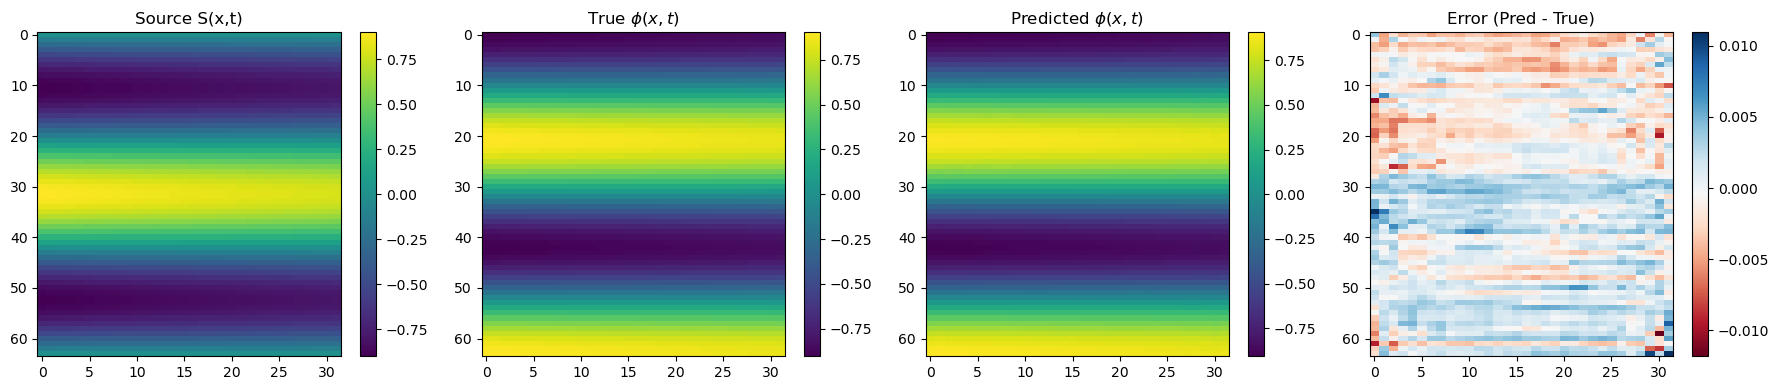

In [64]:
import matplotlib.pyplot as plt

# Move tensors to CPU and remove extra dimensions
S_cpu = S_new.cpu().squeeze().numpy()
phi_true_cpu = phi_true.cpu().squeeze().numpy()
phi_pred_cpu = phi_pred.cpu().squeeze().numpy()
phi_err_cpu = phi_pred_cpu - phi_true_cpu

# Plot
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

im0 = axs[0].imshow(S_cpu, cmap='viridis', aspect='auto')
axs[0].set_title('Source S(x,t)')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(phi_true_cpu, cmap='viridis', aspect='auto')
axs[1].set_title('True $\phi(x,t)$')
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(phi_pred_cpu, cmap='viridis', aspect='auto')
axs[2].set_title('Predicted $\phi(x,t)$')
plt.colorbar(im2, ax=axs[2])

im3 = axs[3].imshow(phi_err_cpu, cmap='RdBu', aspect='auto')
axs[3].set_title('Error (Pred - True)')
plt.colorbar(im3, ax=axs[3])

plt.tight_layout()
plt.show()


In [65]:
# Assume: model is already trained and frozen
model.eval()

# Move target to device
# amplitude A0 ~ [-1,1], frequency k0 ~ 1-3 integer, decay rate alpha0 ~ [0,2]
A0 = 1.
k0 = 2
alpha0 = 0.5
nx = 64
nt = 32
x = torch.linspace(0, 1, nx)
t = torch.linspace(0, 1, nt)
X, T = torch.meshgrid(x, t, indexing="ij")
S_target = A0 * torch.sin(k0 * torch.pi * X) * torch.exp(-alpha0 * T)
phi_target = A0 * torch.cos(k0 * torch.pi * X) * torch.exp(-0.5 * alpha0 * T)
# Add batch and channel dims for model input/output
phi_target = phi_target.unsqueeze(0).unsqueeze(0).to(device)  # (1,1,nx,nt)

'''
# Initialize S as a learnable parameter for both x & t
S_init = torch.randn_like(phi_target, requires_grad=True, device=device)  # Random initialization
S = S_init.clone().detach().to(device)
S = S.unsqueeze(0).unsqueeze(0)  # shape becomes (1, 1, 64, 32)
print(S.shape)
S.requires_grad_(True)
# Optimizer for S (not model parameters!)
optimizer = torch.optim.Adam([S], lr=1e-2)
'''


t = torch.linspace(0, 1, nt).to(device)
g_t = torch.exp(-alpha0 * t).unsqueeze(0).unsqueeze(0)  # (1,1,nt)

f_x = torch.randn(1,1,nx,1, requires_grad=True, device=device)

optimizer = torch.optim.Adam([f_x], lr=1e-3)
loss_fn = nn.MSELoss()

n_iter = 20000
for it in range(n_iter):
    optimizer.zero_grad()
    
    S = f_x * g_t   # (1,1,nx,nt)
    
    phi_pred = model(S)
    loss = loss_fn(phi_pred, phi_target)
    
    loss.backward()
    optimizer.step()
    
    if it % 50 == 0:
        print(f"Iter {it}: Loss = {loss.item():.6f}")

S_pred = (f_x * g_t).detach()




Iter 0: Loss = 2.058978
Iter 50: Loss = 1.816114
Iter 100: Loss = 1.598762
Iter 150: Loss = 1.412913
Iter 200: Loss = 1.278108
Iter 250: Loss = 1.164476
Iter 300: Loss = 1.060413
Iter 350: Loss = 0.965883
Iter 400: Loss = 0.883290
Iter 450: Loss = 0.806920
Iter 500: Loss = 0.737195
Iter 550: Loss = 0.674789
Iter 600: Loss = 0.618336
Iter 650: Loss = 0.568325
Iter 700: Loss = 0.524959
Iter 750: Loss = 0.487237
Iter 800: Loss = 0.454678
Iter 850: Loss = 0.425393
Iter 900: Loss = 0.396584
Iter 950: Loss = 0.360936
Iter 1000: Loss = 0.335402
Iter 1050: Loss = 0.314674
Iter 1100: Loss = 0.293414
Iter 1150: Loss = 0.270806
Iter 1200: Loss = 0.211645
Iter 1250: Loss = 0.178345
Iter 1300: Loss = 0.155479
Iter 1350: Loss = 0.139939
Iter 1400: Loss = 0.129918
Iter 1450: Loss = 0.121129
Iter 1500: Loss = 0.113210
Iter 1550: Loss = 0.106212
Iter 1600: Loss = 0.099913
Iter 1650: Loss = 0.092936
Iter 1700: Loss = 0.081434
Iter 1750: Loss = 0.073695
Iter 1800: Loss = 0.061319
Iter 1850: Loss = 0.0533

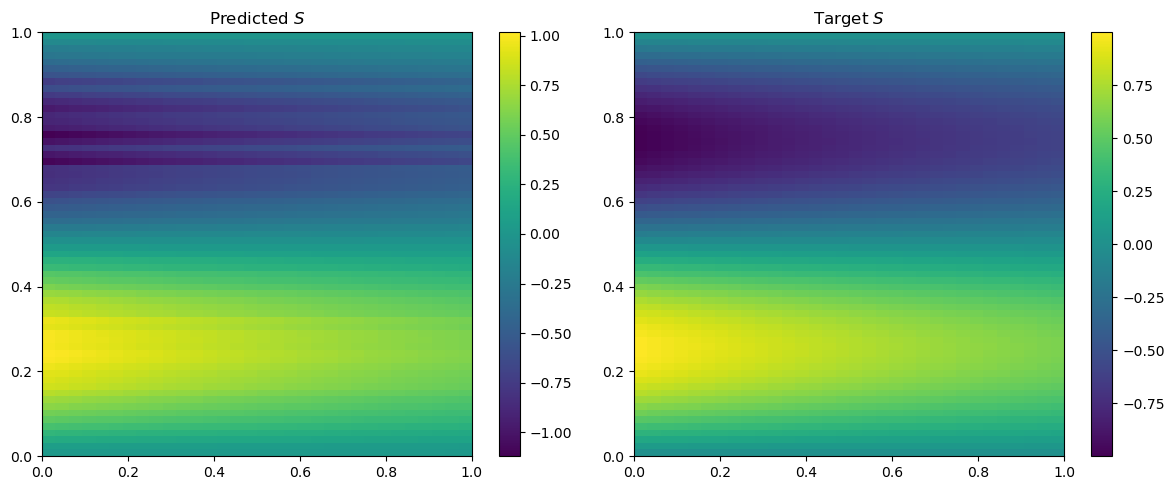

In [66]:
S_pred = S_pred.squeeze(0).squeeze(0).cpu().detach()
S_target = S_target.squeeze(0).squeeze(0).cpu().detach()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(S_pred, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
axes[0].set_title('Predicted $S$')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(S_target, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
axes[1].set_title('Target $S$')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()